In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive
Using device: cuda


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/datasets/subtask_1/en/train.tsv',sep='\t')
train_data = train_data.reset_index(drop=True)
print(train_data.head())

      id                                               text      label
0  12322  you need to stop the engine and wait until it ...  generated
1   1682  The Commission shall publish the report; an in...  generated
2  22592  I have not been tweeting a lot lately, but I d...  generated
3  17390  I pass my exam and really thankgod for that bu...      human
4  30453  The template will have 3 parts: a mustache sha...      human


In [4]:
from sklearn.model_selection import train_test_split
train_data_texts = train_data['text'].to_list()
train_data_labels = train_data['label'].to_list()
train_texts, test_texts, train_labels, test_labels = train_test_split(train_data_texts, train_data_labels, test_size=0.1)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1)
print('train data size: ', len(train_texts))
print('validation data size: ', len(val_texts))
print('test data size: ', len(test_texts))


train data size:  27414
validation data size:  3046
test data size:  3385


In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
def generate_paraphrase(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(input_ids, num_beams=10, max_length=500, early_stopping=True, repetition_penalty=2.5, length_penalty=1.0)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [8]:
#paraphrasing train_texts
from tqdm import tqdm
paraphrased_train_texts = []
for text in tqdm(train_texts[:100]):
    paraphrased_train_texts.append(generate_paraphrase(text))

#print 10 paraphrased texts
for i in range(10):
    print("\n")
    print(train_texts[i])
    print(paraphrased_train_texts[i])
    print("---------------------------")
    print("\n")

100%|██████████| 100/100 [19:19<00:00, 11.60s/it]



Once you have the wig off, use a sharp pair of scissors to cut the wig cap right along the lines that you drew. Do not cut right next to the left weft; you will be adding one more. Anchor the weft to the edge of the wig cap with a doubleknot. Sew the weft to the part, this time looping the thread over the raw, cut edge. When you reach the opposite end, knot and cut the thread
the right weft; do not cut right next to the left weft. Anchor the weft to the edge of the wig cap, this time looping the thread over the raw, cut edge. Sew the weft to the part that you drew. When you reach the opposite end, knot and cut the thread.
---------------------------




For the 2000/01 marketing year, the advance referred to in Article 17a(1) of Regulation (EEC) No 2261/84 shall be: TABLE. Article 2. This Regulation shall enter into force on the third day following its publication in the Official Journal of the European Communities. This Regulation shall be binding in its entirety and directly applic

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load language model and tokenizer
model_name = 'gpt2' # or any other causal LM model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Define function to calculate log probability of a sentence
def calculate_log_prob(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    with torch.no_grad():
        logits = model(input_ids).logits
    log_prob = 0.0
    for i in range(1, input_ids.shape[1]):
        log_prob += logits[0, i-1, input_ids[0, i]].item()
    return log_prob


In [11]:
#calculate for train_texts
from tqdm import tqdm
train_log_probs = []
para_train_log_probs = []
for text in tqdm(train_texts[:100]):
    train_log_probs.append(calculate_log_prob(text))
for text in tqdm(paraphrased_train_texts):
    para_train_log_probs.append(calculate_log_prob(text))

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [12]:
train_data = pd.DataFrame({'text':train_texts[:100], 'label':train_labels[:100], 'log_prob':train_log_probs, 'para_log_prob':para_train_log_probs})
print(train_data.head(10))


                                                text      label     log_prob  \
0  Once you have the wig off, use a sharp pair of...      human -9340.289545   
1  For the 2000/01 marketing year, the advance re...      human -7189.046919   
2  @MrFlungabunga when it starts beatboxing and r...      human -1420.139591   
3  We all want to be fashionable, cool, and look ...      human -9932.740870   
4  When Member States adopt these measures, they ...      human -9640.751480   
5  1. Article 1. This Regulation shall apply to v...  generated -6993.298683   
6  Member States shall communicate to the Commiss...      human -6425.842509   
7  If the burn is minor and does not require medi...  generated -8494.827195   
8  Article 1. For imports of uniflorous (bloom) c...      human -9397.204479   
9  @CompanyManComic Just repost last nights reply...  generated -2435.748230   

   para_log_prob  
0   -6109.394477  
1   -4137.220655  
2   -6140.192827  
3   -4985.535255  
4   -4435.414854  
5   -

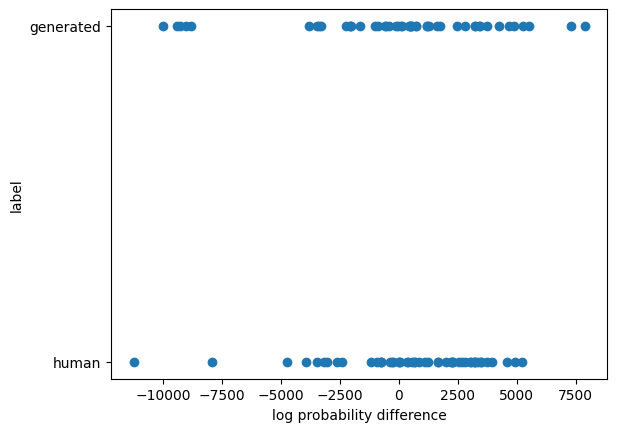

In [16]:
#calculate difference in log probability
train_data['diff_log_prob'] = train_data['para_log_prob'] - train_data['log_prob']

#plot the log probability difference scores with label
plt.scatter(train_data['diff_log_prob'], train_data['label'])
plt.xlabel('log probability difference')
plt.ylabel('label')
plt.show()